In [51]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.nddata import CCDData
import astropy.units as u
from glob import glob
import os
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch, AsymmetricPercentileInterval
import h5py 
from PIL import Image
from datetime import datetime, timedelta
from ccdproc import ImageFileCollection
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoLocator, AutoMinorLocator, FixedLocator, FixedFormatter, LogLocator
import cmcrameri.cm as cmcm
from juanfit import SpectrumFitSingle, SpectrumFitRow
from specutils.utils.wcs_utils import vac_to_air, air_to_vac
from scipy import ndimage
from scipy.interpolate import interp1d

In [2]:
with h5py.File("../../sav/Eclipse/Bias/master_bias_dc_green_1s_proto.h5", 'r') as hf:
    bias_dc_green_1s = hf['image'][:]


In [3]:
green_path = "../../src/EclipseSpectra2017/MikesData/VaderEclipseDayGreen2017aug21/"
helium_im_collection = ImageFileCollection(green_path,glob_include="HeliumGreenpoint1s_2465*.fit")
                            # filenames=["HeliumGreenpoint1s_24605.fit","HeliumGreenpoint1s_24606.fit","HeliumGreenpoint1s_24607.fit",
                            # "HeliumGreenpoint1s_24608.fit","HeliumGreenpoint1s_24609.fit","HeliumGreenpoint1s_24610.fit",
                            # "HeliumGreenpoint1s_24611.fit","HeliumGreenpoint1s_24612.fit","HeliumGreenpoint1s_24613.fit",
                            # "HeliumGreenpoint1s_24614.fit"])
helium_im_df = helium_im_collection.summary.to_pandas()

In [4]:
helium_im_df

file  simple  bitpix  naxis  naxis1  naxis2  \
0  HeliumGreenpoint1s_24650.fit    True      16      2    1392    1040   
1  HeliumGreenpoint1s_24651.fit    True      16      2    1392    1040   
2  HeliumGreenpoint1s_24652.fit    True      16      2    1392    1040   
3  HeliumGreenpoint1s_24653.fit    True      16      2    1392    1040   
4  HeliumGreenpoint1s_24654.fit    True      16      2    1392    1040   
5  HeliumGreenpoint1s_24655.fit    True      16      2    1392    1040   
6  HeliumGreenpoint1s_24656.fit    True      16      2    1392    1040   
7  HeliumGreenpoint1s_24657.fit    True      16      2    1392    1040   
8  HeliumGreenpoint1s_24658.fit    True      16      2    1392    1040   
9  HeliumGreenpoint1s_24659.fit    True      16      2    1392    1040   

     bzero  bscale  datamin  datamax  ... ypixsz  xbinning ybinning  xorgsubf  \
0  32768.0     1.0      0.0  65535.0  ...   6.45         1        1         0   
1  32768.0     1.0      0.0  65535.0  ...   6.45         1        1         0   
2  32768.0     1.0      0.0  65535.0  ...   6.45         1        1         0   
3  32768.0     1.0      0.0  65535.0  ...   6.45         1        1         0   
4  32768.0     1.0      0.0  65535.0  ...   6.45         1        1         0   
5  32768.0     1.0      0.0  65535.0  ...   6.45         1        1         0   
6  32768.0     1.0      0.0  65535.0  ...   6.45         1        1         0   
7  32768.0     1.0      0.0  65535.0  ...   6.45         1        1         0   
8  32768.0     1.0      0.0  65535.0  ...   6.45         1        1         0   
9  32768.0     1.0      0.0  65535.0  ...   6.45         1        1         0   

   yorgsubf  xpossubf  ypossubf  cblack  cwhite         swcreate  
0         0         0         0     756   30056  Artemis Capture  
1         0         0         0     756   30781  Artemis Capture  
2         0         0         0     747   31067  Artemis Capture  
3         0         0         0     759   30684  Artemis Capture  
4         0         0         0     755   29932  Artemis Capture  
5         0         0         0     757   30677  Artemis Capture  
6         0         0         0     757   29019  Artemis Capture  
7         0         0         0     752   29345  Artemis Capture  
8         0         0         0     757   30203  Artemis Capture  
9         0         0         0     756   30207  Artemis Capture  

[10 rows x 24 columns]

In [5]:
helium_image_cube = np.zeros((1040,1392,10))

for ii, row_ in helium_im_df.iterrows():
    helium_image_cube[:,:,ii] = CCDData.read(os.path.join(green_path,row_["file"]),unit="adu").data - bias_dc_green_1s

/tmp/ipykernel_225533/3833146242.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)


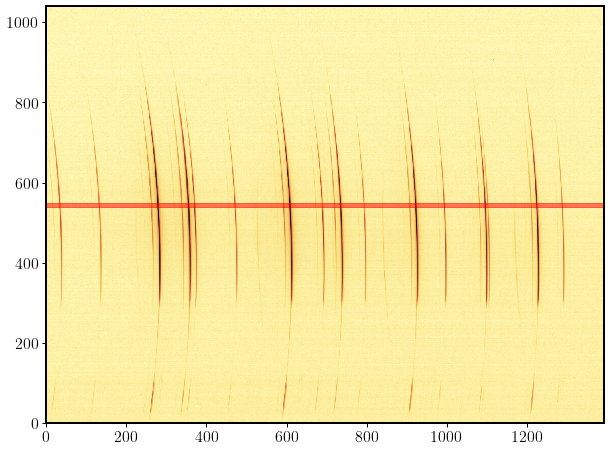

In [6]:
helium_im_aver = np.mean(helium_image_cube,axis=2)
norm = ImageNormalize(helium_im_aver, stretch=LogStretch())
fig, ax = plt.subplots(figsize=(10,8))
im = ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
#plt.colorbar(im)
ax.axis("scaled")
bottom_pixel = 540
top_pixel = 550
ax.axhspan(bottom_pixel,top_pixel,color="red",alpha=0.5)

ax.tick_params(labelsize=16)

In [7]:
with h5py.File("../../sav/Eclipse/Curvature/master_curvature_green.h5", 'r') as hf:
    xpos_map_coordinate = hf['xpos_map_coordinate'][:]
    xstart_pixel = hf['xpos_map_coordinate'].attrs['xstart_pixel']
    xend_pixel = hf['xpos_map_coordinate'].attrs['xend_pixel']

    ypos_map_coordinate = hf['ypos_map_coordinate'][:]
    ystart_pixel = hf['ypos_map_coordinate'].attrs['ystart_pixel']
    yend_pixel = hf['ypos_map_coordinate'].attrs['yend_pixel']


In [8]:
testx_slice_mapcoor = slice(xstart_pixel,xend_pixel)
testy_slice_mapcoor = slice(ystart_pixel,yend_pixel)
helium_trans_mapcoor = ndimage.map_coordinates(helium_im_aver[testy_slice_mapcoor, testx_slice_mapcoor],(ypos_map_coordinate, xpos_map_coordinate),
                                                order=1)

/tmp/ipykernel_225533/1045579072.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),


Text(0, 0.5, '')

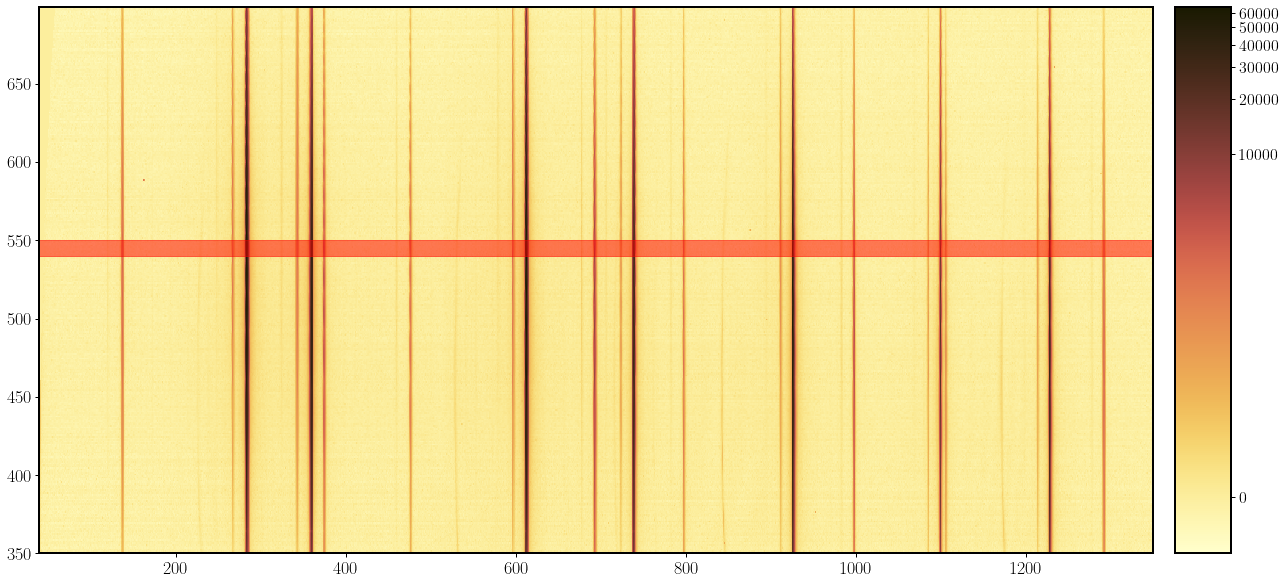

In [9]:
fig, ax = plt.subplots(figsize=(16,8),constrained_layout=True)
im = ax.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            helium_trans_mapcoor,norm=norm,cmap=cmcm.lajolla,rasterized=True)
ax.tick_params(labelsize=18)
ax.axhspan(bottom_pixel,top_pixel,color="red",alpha=0.5)
clb_ax = inset_axes(ax,width="5%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
clb_ax.tick_params(labelsize=16)
clb_ax.yaxis.get_offset_text().set_fontsize(16)
clb_ax.set_ylabel('',fontsize=16)

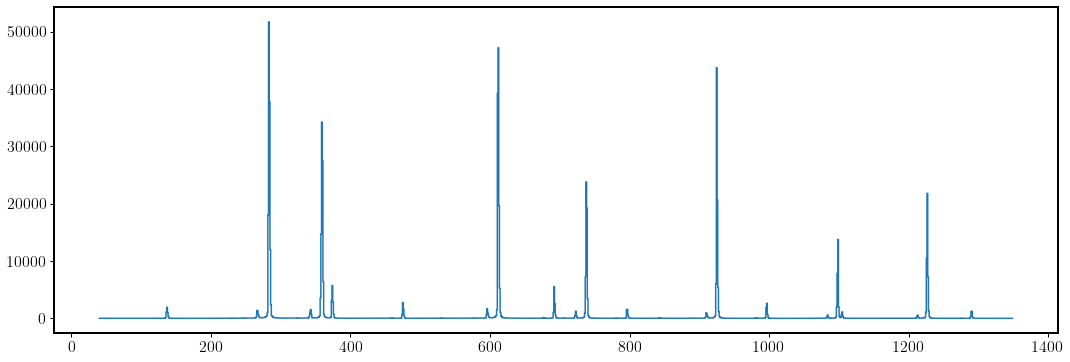

In [10]:
helium_spectrum_example = np.mean(helium_trans_mapcoor[bottom_pixel - ystart_pixel:top_pixel - ystart_pixel,:],axis=0)
fig, ax = plt.subplots(figsize=(18,6))
ccdx_array = np.arange(xstart_pixel, xend_pixel)
ax.step(ccdx_array, helium_spectrum_example,where="mid")
ax.tick_params(labelsize=16)

<AxesSubplot:ylabel='Intensity'>

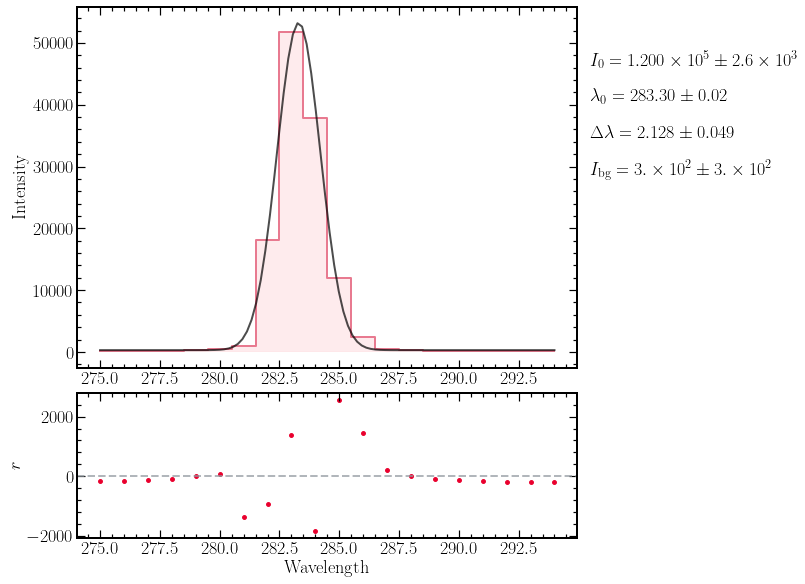

In [11]:
HeI_5016_slice_1 = slice(275 - xstart_pixel ,295 - xstart_pixel)
HeI_5016_model_1 = SpectrumFitSingle(data=helium_spectrum_example[HeI_5016_slice_1], wvl=ccdx_array[HeI_5016_slice_1],line_number=1,line_wvl_init=[283],
                    int_max_init=[12000],fwhm_init=[1],same_width=False)
HeI_5016_model_1.run_lse(absolute_sigma=False)
HeI_5016_model_1.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

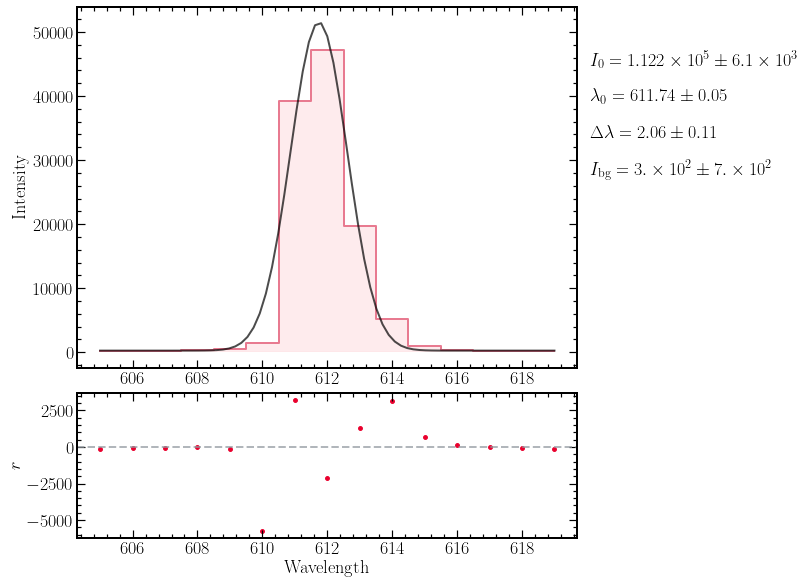

In [12]:
HeI_5016_slice_2 = slice(605 - xstart_pixel,620 - xstart_pixel)
HeI_5016_model_2 = SpectrumFitSingle(data=helium_spectrum_example[HeI_5016_slice_2], wvl=ccdx_array[HeI_5016_slice_2],line_number=1,line_wvl_init=[612],
                    int_max_init=[12000],fwhm_init=[2],same_width=False)
HeI_5016_model_2.run_lse(absolute_sigma=False)
HeI_5016_model_2.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

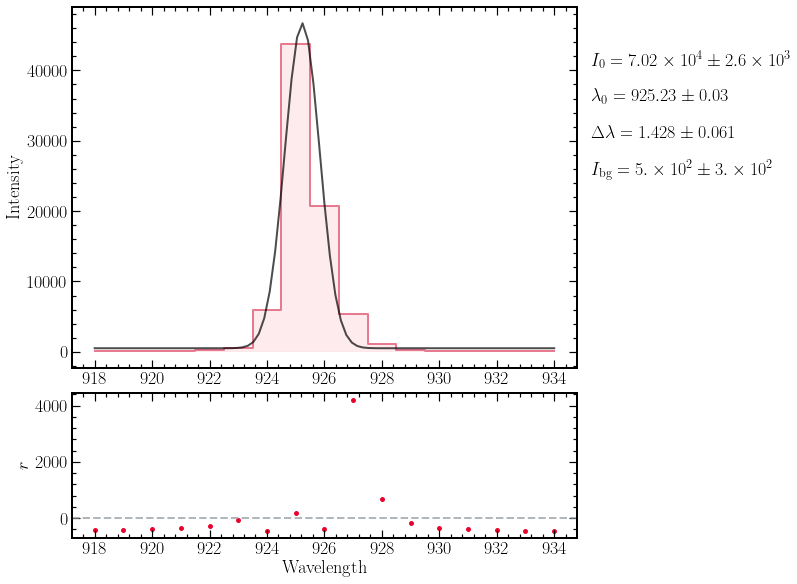

In [13]:
HeI_5016_slice_3 = slice(918 - xstart_pixel,935 - xstart_pixel)
HeI_5016_model_3 = SpectrumFitSingle(data=helium_spectrum_example[HeI_5016_slice_3], wvl=ccdx_array[HeI_5016_slice_3],line_number=1,line_wvl_init=[925],
                    int_max_init=[6000],fwhm_init=[2],same_width=False)
HeI_5016_model_3.run_lse(absolute_sigma=False)
HeI_5016_model_3.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

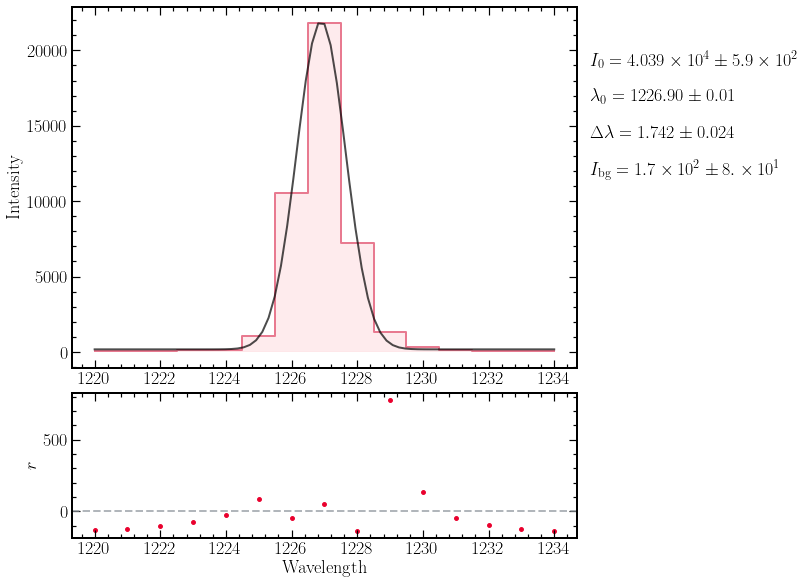

In [14]:
HeI_5016_slice_4 = slice(1220 - xstart_pixel,1235 - xstart_pixel)
HeI_5016_model_4 = SpectrumFitSingle(data=helium_spectrum_example[HeI_5016_slice_4], wvl=ccdx_array[HeI_5016_slice_4],line_number=1,line_wvl_init=[1227],
                    int_max_init=[2000],fwhm_init=[2],same_width=False)
HeI_5016_model_4.run_lse(absolute_sigma=False)
HeI_5016_model_4.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

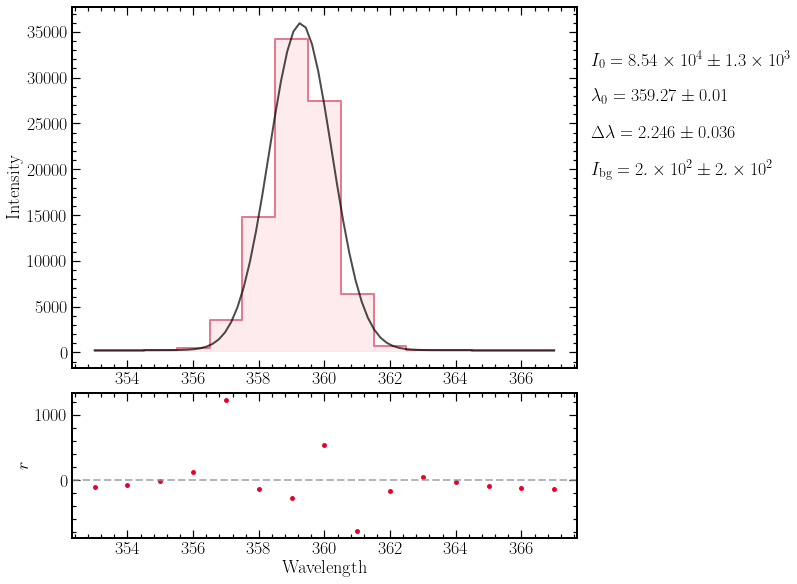

In [15]:
HeI_D3_slice_1 = slice(353 - xstart_pixel,368 - xstart_pixel)
HeI_D3_model_1 = SpectrumFitSingle(data=helium_spectrum_example[HeI_D3_slice_1], wvl=ccdx_array[HeI_D3_slice_1],line_number=1,line_wvl_init=[359],
                    int_max_init=[8000],fwhm_init=[1],same_width=False)
HeI_D3_model_1.run_lse(absolute_sigma=False)
HeI_D3_model_1.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

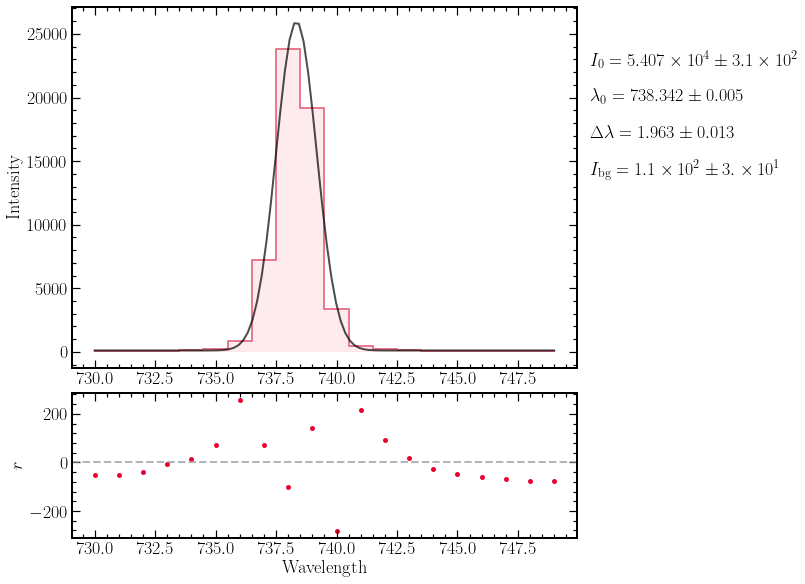

In [16]:
HeI_D3_slice_2 = slice(730 - xstart_pixel,750 - xstart_pixel)
HeI_D3_model_2 = SpectrumFitSingle(data=helium_spectrum_example[HeI_D3_slice_2], wvl=ccdx_array[HeI_D3_slice_2],line_number=1,line_wvl_init=[738],
                    int_max_init=[4000],fwhm_init=[1],same_width=False)
HeI_D3_model_2.run_lse(absolute_sigma=False)
HeI_D3_model_2.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

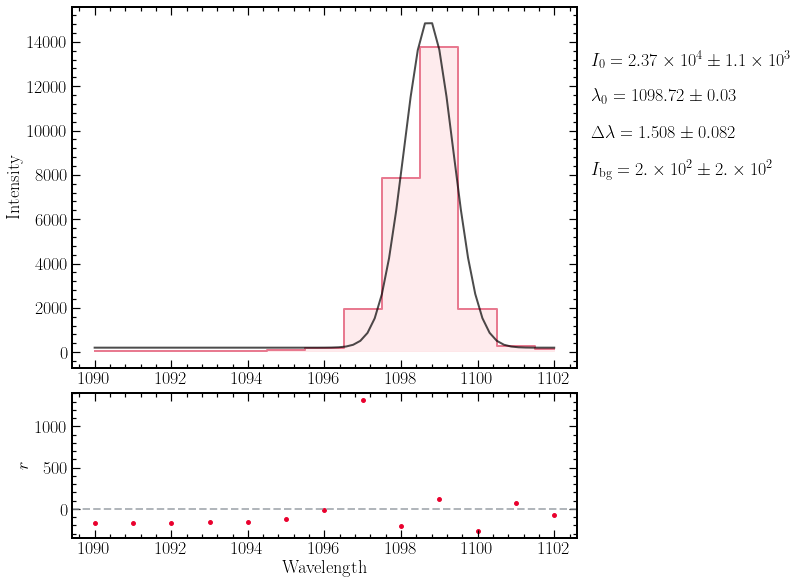

In [17]:
HeI_D3_slice_3 = slice(1090 - xstart_pixel,1103 - xstart_pixel)
HeI_D3_model_3 = SpectrumFitSingle(data=helium_spectrum_example[HeI_D3_slice_3], wvl=ccdx_array[HeI_D3_slice_3],line_number=1,line_wvl_init=[1099],
                    int_max_init=[14000],fwhm_init=[2],same_width=False)
HeI_D3_model_3.run_lse(absolute_sigma=False)
HeI_D3_model_3.plot(plot_fit=True)

In [18]:
HeI_5016_pos = np.array([HeI_5016_model.line_wvl_fit[0] for HeI_5016_model in 
                    (HeI_5016_model_1, HeI_5016_model_2, HeI_5016_model_3, HeI_5016_model_4)])
HeI_D3_pos = np.array([HeI_D3_model.line_wvl_fit[0] for HeI_D3_model in 
                    (HeI_D3_model_1, HeI_D3_model_2, HeI_D3_model_3)])

In [19]:
HeI_5016_pos[1:] - HeI_5016_pos[:-1]

array([328.43647677, 313.48734995, 301.6715564 ])

In [20]:
HeI_D3_pos[1:] - HeI_D3_pos[:-1]

array([379.06947074, 360.3772938 ])

In [21]:
hydrogen_im_collection = ImageFileCollection(green_path,
                            glob_include="HydrogenGreen1s_2471*.fit")
hydrogen_im_df = hydrogen_im_collection.summary.to_pandas()

In [22]:
hydrogen_im_df

file  simple  bitpix  naxis  naxis1  naxis2    bzero  \
0  HydrogenGreen1s_24710.fit    True      16      2    1392    1040  32768.0   
1  HydrogenGreen1s_24711.fit    True      16      2    1392    1040  32768.0   
2  HydrogenGreen1s_24712.fit    True      16      2    1392    1040  32768.0   
3  HydrogenGreen1s_24713.fit    True      16      2    1392    1040  32768.0   
4  HydrogenGreen1s_24714.fit    True      16      2    1392    1040  32768.0   
5  HydrogenGreen1s_24715.fit    True      16      2    1392    1040  32768.0   
6  HydrogenGreen1s_24716.fit    True      16      2    1392    1040  32768.0   
7  HydrogenGreen1s_24717.fit    True      16      2    1392    1040  32768.0   
8  HydrogenGreen1s_24718.fit    True      16      2    1392    1040  32768.0   
9  HydrogenGreen1s_24719.fit    True      16      2    1392    1040  32768.0   

   bscale  datamin  datamax  ... ypixsz  xbinning ybinning  xorgsubf  \
0     1.0      0.0  65535.0  ...   6.45         1        1         0   
1     1.0      0.0  65535.0  ...   6.45         1        1         0   
2     1.0      0.0  65535.0  ...   6.45         1        1         0   
3     1.0      0.0  65535.0  ...   6.45         1        1         0   
4     1.0      0.0  65535.0  ...   6.45         1        1         0   
5     1.0      0.0  65535.0  ...   6.45         1        1         0   
6     1.0      0.0  65535.0  ...   6.45         1        1         0   
7     1.0      0.0  65535.0  ...   6.45         1        1         0   
8     1.0      0.0  65535.0  ...   6.45         1        1         0   
9     1.0      0.0  65535.0  ...   6.45         1        1         0   

   yorgsubf  xpossubf  ypossubf  cblack  cwhite         swcreate  
0         0         0         0     760    7179  Artemis Capture  
1         0         0         0     763    8029  Artemis Capture  
2         0         0         0     759    8628  Artemis Capture  
3         0         0         0     763    6774  Artemis Capture  
4         0         0         0     763    6873  Artemis Capture  
5         0         0         0     762   10427  Artemis Capture  
6         0         0         0     763   10391  Artemis Capture  
7         0         0         0     762   10278  Artemis Capture  
8         0         0         0     762   10415  Artemis Capture  
9         0         0         0     762   10398  Artemis Capture  

[10 rows x 24 columns]

In [23]:
hydrogen_image_cube = np.zeros((1040,1392,10))

for ii, row_ in hydrogen_im_df.iterrows():
    hydrogen_image_cube[:,:,ii] = CCDData.read(os.path.join(green_path,row_["file"]),unit="adu").data - bias_dc_green_1s

/tmp/ipykernel_225533/2619521313.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(np.arange(1392),np.arange(1040),hydrogen_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True,)


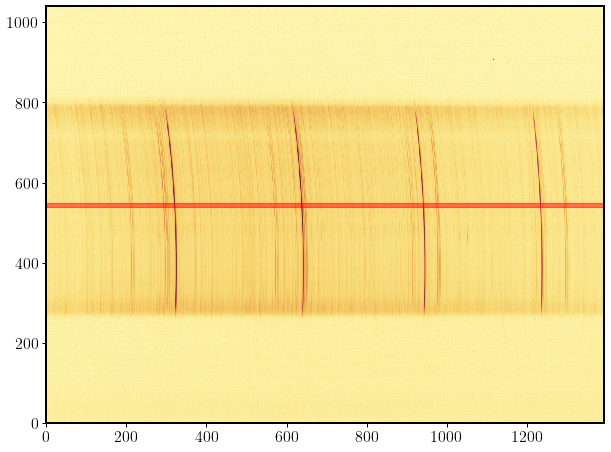

In [24]:
hydrogen_im_aver = np.mean(hydrogen_image_cube,axis=2)
norm = ImageNormalize(hydrogen_im_aver, stretch=LogStretch())
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),hydrogen_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True,)
ax.axis("scaled")
ax.axhspan(bottom_pixel,top_pixel,color="red",alpha=0.5)

ax.tick_params(labelsize=16)

In [25]:
hydrogen_trans_mapcoor = ndimage.map_coordinates(hydrogen_im_aver[testy_slice_mapcoor, testx_slice_mapcoor],(ypos_map_coordinate, xpos_map_coordinate),
                                                order=1)

/tmp/ipykernel_225533/3870109621.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),


Text(0, 0.5, '')

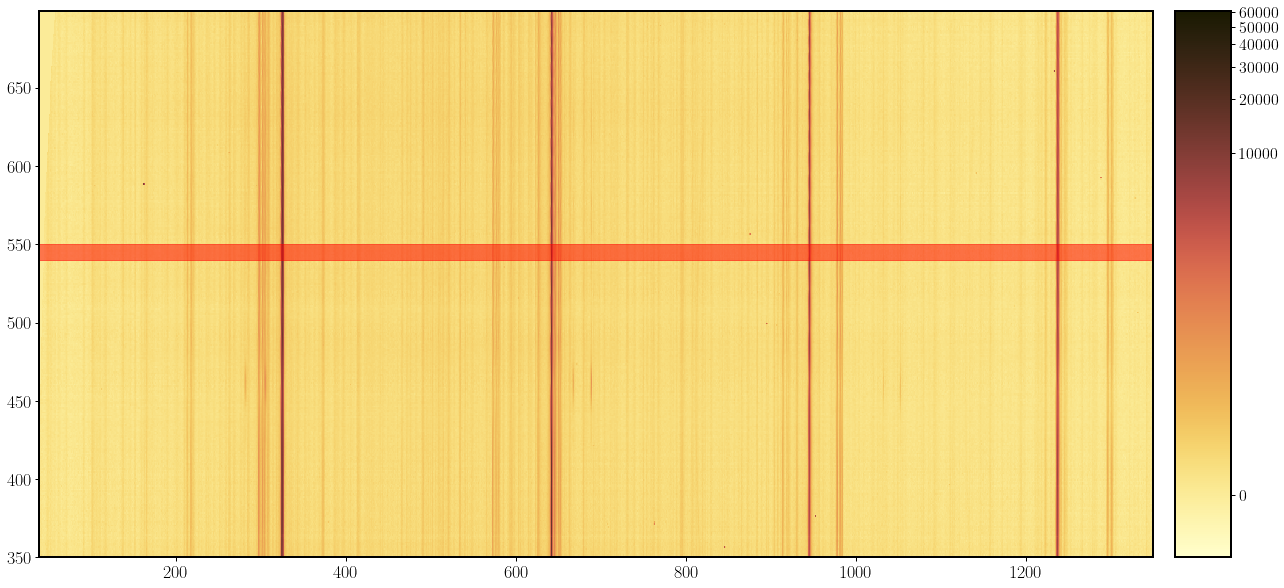

In [26]:
fig, ax = plt.subplots(figsize=(16,8),constrained_layout=True)
im = ax.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            hydrogen_trans_mapcoor,norm=norm,cmap=cmcm.lajolla,rasterized=True)
ax.tick_params(labelsize=18)
ax.axhspan(bottom_pixel,top_pixel,color="red",alpha=0.5)
clb_ax = inset_axes(ax,width="5%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
clb_ax.tick_params(labelsize=16)
clb_ax.yaxis.get_offset_text().set_fontsize(16)
clb_ax.set_ylabel('',fontsize=16)

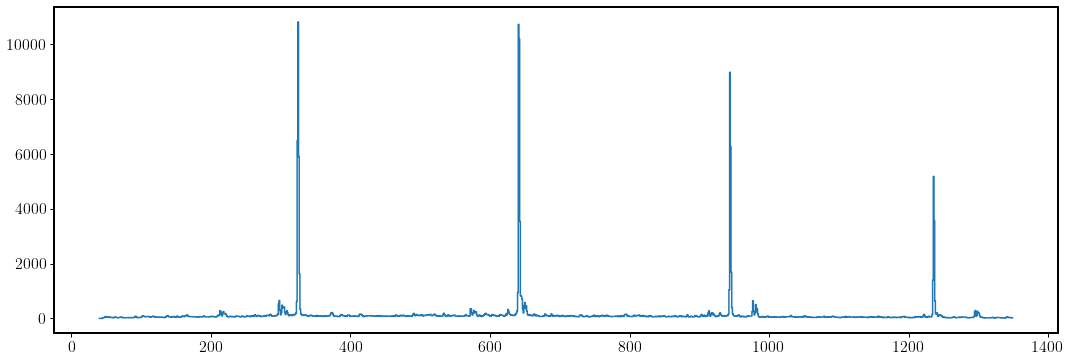

In [27]:
hydrogen_spectrum_example = np.mean(hydrogen_trans_mapcoor[bottom_pixel - ystart_pixel:top_pixel - ystart_pixel,:],axis=0)
fig, ax = plt.subplots(figsize=(18,6))
ax.step(ccdx_array, hydrogen_spectrum_example,where="mid")
ax.tick_params(labelsize=16)

<AxesSubplot:ylabel='Intensity'>

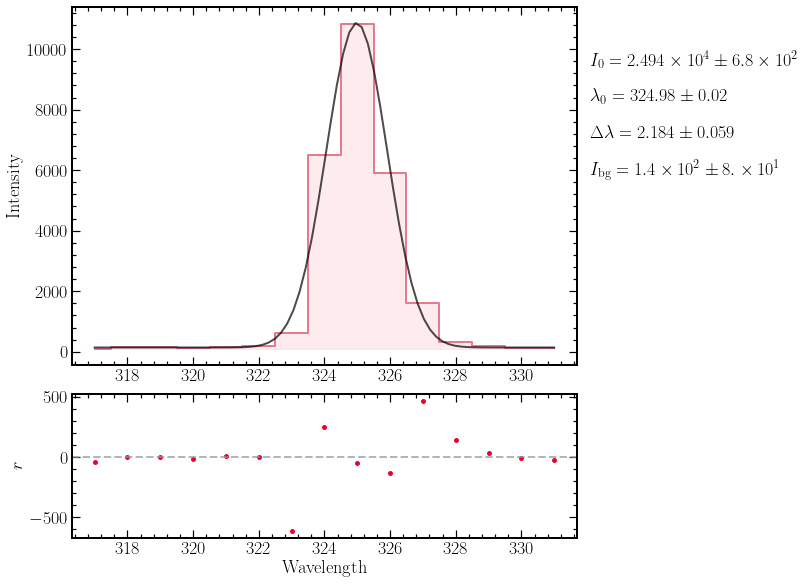

In [28]:
Hbeta_slice_1 = slice(317 - xstart_pixel,332 - xstart_pixel)
Hbeta_model_1 = SpectrumFitSingle(data=hydrogen_spectrum_example[Hbeta_slice_1], wvl=ccdx_array[Hbeta_slice_1],line_number=1,line_wvl_init=[325],
                    int_max_init=[10000],fwhm_init=[1],same_width=False)
Hbeta_model_1.run_lse(absolute_sigma=False)
Hbeta_model_1.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

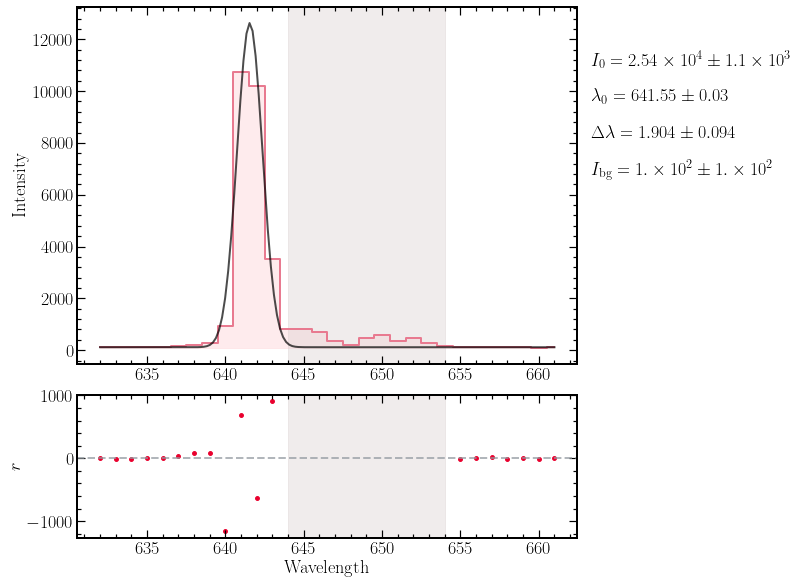

In [29]:
Hbeta_slice_2 = slice(632 - xstart_pixel,662 - xstart_pixel)
Hbeta_model_2 = SpectrumFitSingle(data=hydrogen_spectrum_example[Hbeta_slice_2], wvl=ccdx_array[Hbeta_slice_2],line_number=1,line_wvl_init=[642],
                    int_max_init=[12000],fwhm_init=[1],same_width=False,mask=[[644,654]])
Hbeta_model_2.run_lse(absolute_sigma=False)
Hbeta_model_2.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

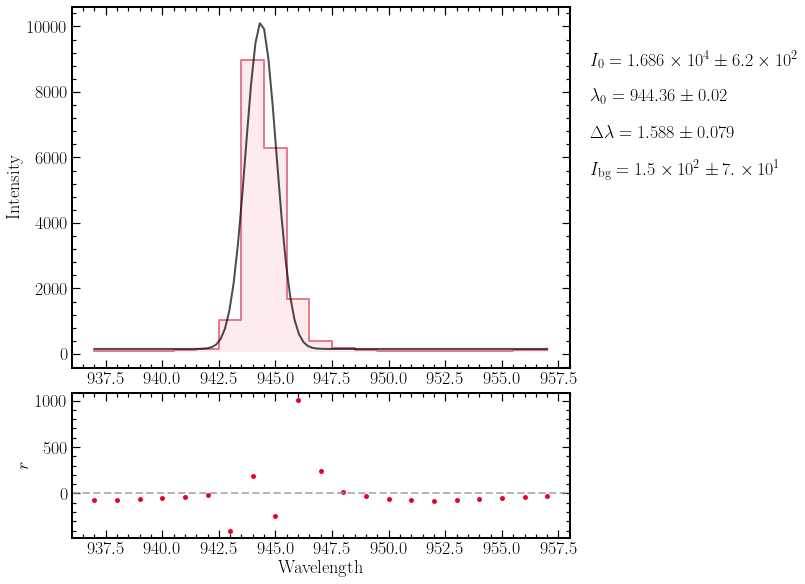

In [30]:
Hbeta_slice_3 = slice(937 - xstart_pixel,958 - xstart_pixel)
Hbeta_model_3 = SpectrumFitSingle(data=hydrogen_spectrum_example[Hbeta_slice_3], wvl=ccdx_array[Hbeta_slice_3],line_number=1,line_wvl_init=[944],
                    int_max_init=[8000],fwhm_init=[1],same_width=False)
Hbeta_model_3.run_lse(absolute_sigma=False)
Hbeta_model_3.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

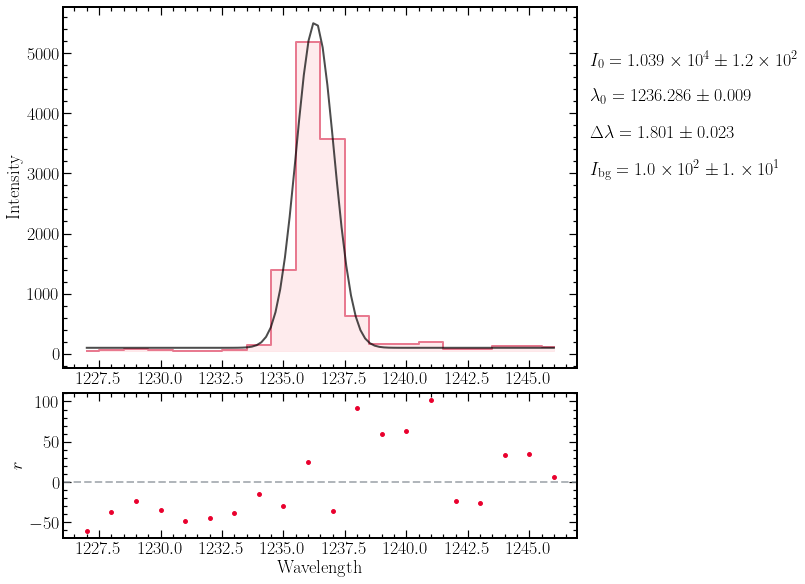

In [31]:
Hbeta_slice_4 = slice(1227 - xstart_pixel,1247 - xstart_pixel)
Hbeta_model_4 = SpectrumFitSingle(data=hydrogen_spectrum_example[Hbeta_slice_4], wvl=ccdx_array[Hbeta_slice_4],line_number=1,line_wvl_init=[1237],
                    int_max_init=[5000],fwhm_init=[1],same_width=False)
Hbeta_model_4.run_lse(absolute_sigma=False)
Hbeta_model_4.plot(plot_fit=True)

In [32]:
Hbeta_pos = np.array([Hbeta_model.line_wvl_fit[0] for Hbeta_model in 
                    (Hbeta_model_1, Hbeta_model_2, Hbeta_model_3, Hbeta_model_4)])

In [33]:
Hbeta_pos[1:] - Hbeta_pos[:-1]

array([316.56661618, 302.80997168, 291.92439985])

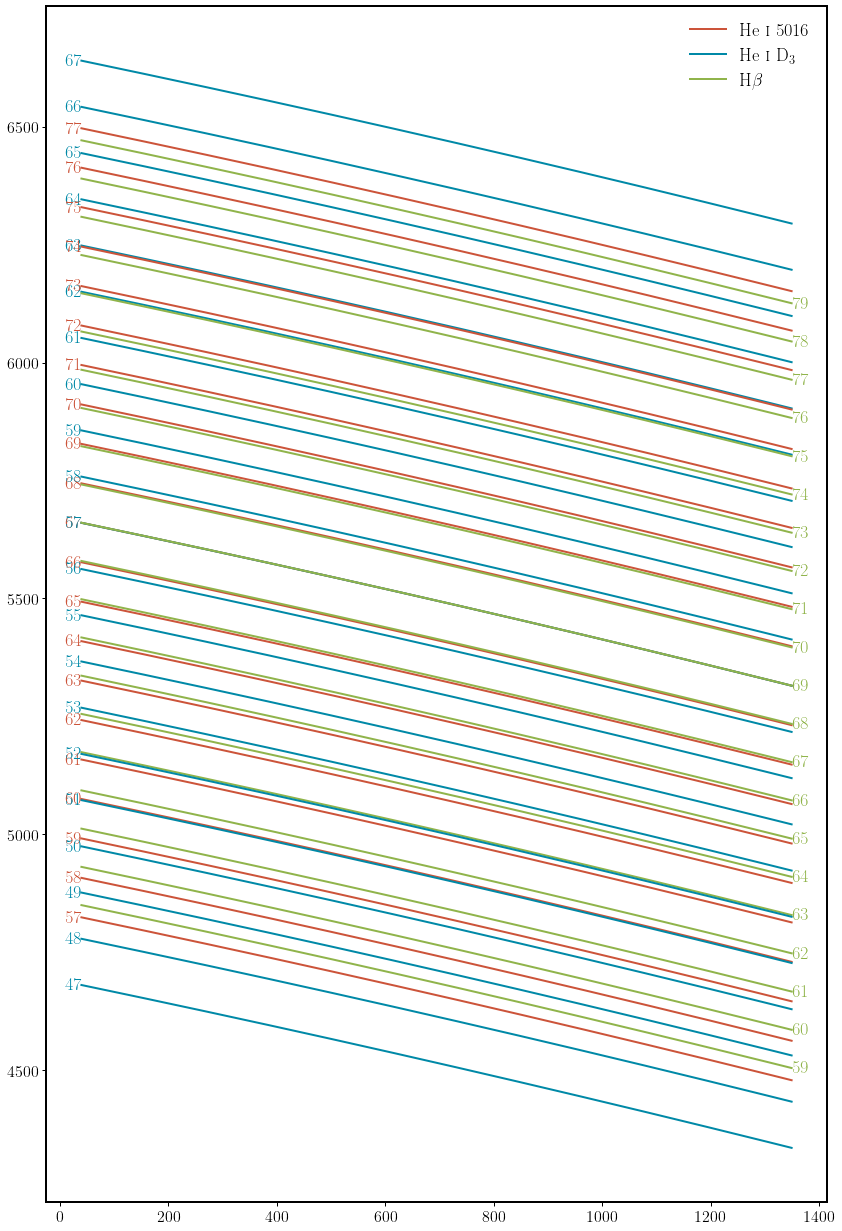

In [34]:
scale_factor = 60
HeI_5016_start_order_guess = 67
HeI_D3_start_order_guess = 57
Hbeta_start_order_guess = 69

order_variation = 10
fig, ax = plt.subplots(figsize=(14,order_variation*2 + 2))

for ii, order_new in enumerate(np.arange(-order_variation, order_variation + 1)):
    HeI_5016_wvl_guess_new = 5015.6783  * np.arange(HeI_5016_start_order_guess + order_new,
                             HeI_5016_start_order_guess + order_new - 4,-1)/scale_factor
    HeI_D3_wvl_guess_new = 5875.621 * np.arange(HeI_D3_start_order_guess + order_new,
                                HeI_D3_start_order_guess + order_new - 3,-1)/scale_factor
    Hbeta_wvl_guess_new = 4861.35 * np.arange(Hbeta_start_order_guess + order_new,
                             Hbeta_start_order_guess + order_new - 4,-1)/scale_factor
    
    poly_fit_5016_param = np.polyfit(HeI_5016_pos, HeI_5016_wvl_guess_new, 2)
    poly_fit_5016_func = np.poly1d(poly_fit_5016_param)
    poly_fit_5016_curve = poly_fit_5016_func(ccdx_array)

    poly_fit_6678_param = np.polyfit(HeI_D3_pos, HeI_D3_wvl_guess_new, 2)
    poly_fit_6678_func = np.poly1d(poly_fit_6678_param)
    poly_fit_6678_curve = poly_fit_6678_func(ccdx_array)

    poly_fit_hbeta_param = np.polyfit(Hbeta_pos, Hbeta_wvl_guess_new, 2)
    poly_fit_hbeta_func = np.poly1d(poly_fit_hbeta_param)
    poly_fit_hbeta_curve = poly_fit_hbeta_func(ccdx_array)

    ln1, = ax.plot(ccdx_array, poly_fit_5016_curve,color="#CC543A",lw=2,
            label=r"He \textsc{i} 5016")
    ax.text(ccdx_array[0], poly_fit_5016_curve[0],"{:2d}".format(HeI_5016_start_order_guess + order_new),
            va="center",ha="right",fontsize=18,color="#CC543A")

    ln2, = ax.plot(ccdx_array, poly_fit_6678_curve,color="#0089A7",lw=2,
            label=r"He \textsc{i} $\rm D_3$")
    ax.text(ccdx_array[0], poly_fit_6678_curve[0],"{:2d}".format(HeI_D3_start_order_guess + order_new),
            va="center",ha="right",fontsize=18,color="#0089A7")

    ln3, = ax.plot(ccdx_array, poly_fit_hbeta_curve,color="#90B44B",lw=2,
            label=r"H$\beta$")
    ax.text(ccdx_array[-1], poly_fit_hbeta_curve[-1],"{:2d}".format(Hbeta_start_order_guess + order_new),
            va="center",ha="left",fontsize=18,color="#90B44B")

    if ii == order_variation*2:
        leg = [ln1,ln2,ln3]
        ax.legend(leg,[leg_.get_label() for leg_ in leg],loc = 'upper right',fontsize = 18,frameon=False)

ax.tick_params(labelsize=16)



Text(0, 0.5, 'Wavelength $\\lambda$\\,[\\mbox{\\AA}]')

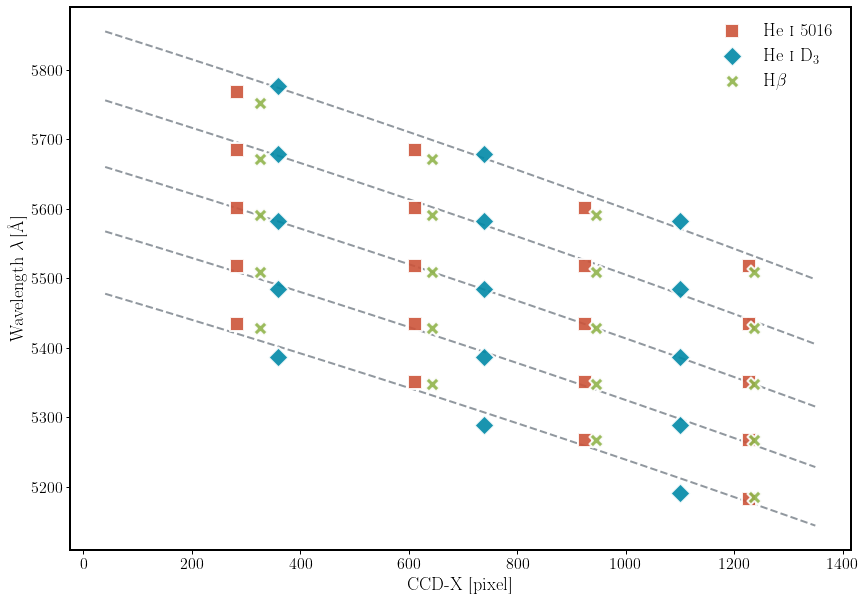

In [35]:
base_order = 60
HeI_5016_start_order_guess = 67
HeI_D3_start_order_guess = 57
Hbeta_start_order_guess = 69

HeI_5016_wvl_guess = 5015.6783 * np.arange(HeI_5016_start_order_guess, HeI_5016_start_order_guess - 4,-1)/base_order
HeI_D3_wvl_guess = 5875.621 * np.arange(HeI_D3_start_order_guess, HeI_D3_start_order_guess - 3,-1)/base_order
Hbeta_wvl_guess = 4861.35 * np.arange(Hbeta_start_order_guess, Hbeta_start_order_guess - 4,-1)/base_order

line_pos_all = np.concatenate([HeI_5016_pos, HeI_D3_pos,Hbeta_pos])
line_wvl_guess_all = np.concatenate([HeI_5016_wvl_guess, HeI_D3_wvl_guess,Hbeta_wvl_guess])

poly_fit_param = np.polyfit(line_pos_all, line_wvl_guess_all, 2)
poly_fit_func = np.poly1d(poly_fit_param)
poly_fit_curve = poly_fit_func(ccdx_array)
green_abs_shift = -5.557
poly_fit_curve_shift = poly_fit_func(ccdx_array - green_abs_shift)

order_variation = 2
fig, ax = plt.subplots(figsize=(14,order_variation*4 + 2))


for ii, order_new in enumerate(np.arange(-order_variation, order_variation + 1)):
    HeI_5016_wvl_guess_new = 5015.6783 * np.arange(HeI_5016_start_order_guess + order_new,
                             HeI_5016_start_order_guess + order_new - 4,-1)/base_order
    HeI_D3_wvl_guess_new = 5875.621 * np.arange(HeI_D3_start_order_guess + order_new,
                                HeI_D3_start_order_guess + order_new - 3,-1)/base_order
    Hbeta_wvl_guess_new = 4861.35 * np.arange(Hbeta_start_order_guess + order_new,
                                Hbeta_start_order_guess + order_new - 4,-1)/base_order

    ln1 = ax.scatter(HeI_5016_pos, HeI_5016_wvl_guess_new,marker= "s",s=200,facecolor="#CC543A",
                alpha=0.9,edgecolor='white',linewidth=2,label=r"He \textsc{i} 5016")
    ln2 = ax.scatter(HeI_D3_pos, HeI_D3_wvl_guess_new,marker= "D",s=200,facecolor="#0089A7",
                alpha=0.9,edgecolor='white',linewidth=2,label=r"He \textsc{i} $\rm D_3$")
    ln3 = ax.scatter(Hbeta_pos, Hbeta_wvl_guess_new,marker= "X",s=200,facecolor="#90B44B",
                alpha=0.9,edgecolor='white',linewidth=2,label=r"H$\beta$")
    if ii == order_variation*2:
        leg = [ln1,ln2,ln3]
        ax.legend(leg,[leg_.get_label() for leg_ in leg],loc = 'upper right',fontsize = 18,frameon=False)

    ax.plot(ccdx_array, poly_fit_curve*base_order/(base_order + order_new),lw=2,ls="--",color="#91989F",zorder=0)


# for plot_order in np.arange(base_order - 5, base_order + 5):
#     ax.scatter()

ax.tick_params(labelsize=16)
ax.set_xlabel("CCD-X [pixel]",fontsize=18)
ax.set_ylabel(r"Wavelength $\lambda$\,[\mbox{\AA}]",fontsize=18)

In [36]:
totality_image_fname = "TotalitySequenceGreen_22717(2).fit"
totality_frame = CCDData.read(os.path.join(green_path, totality_image_fname),unit="adu")

/tmp/ipykernel_225533/940788650.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(np.arange(1392),np.arange(1040),totality_image,norm=norm_totality,cmap=cmcm.lajolla, rasterized=True)


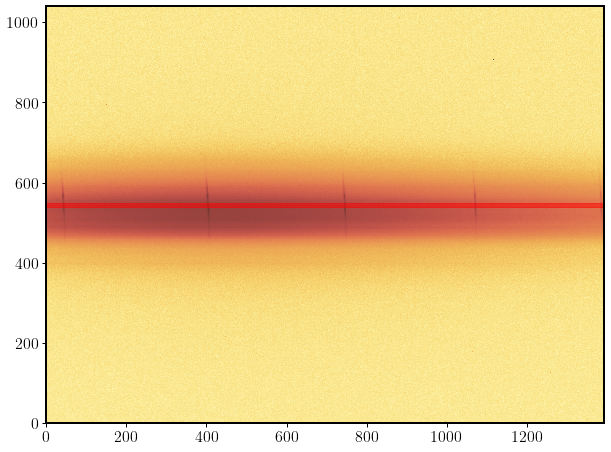

In [37]:
totality_image = (totality_frame.data - bias_dc_green_1s)//totality_frame.header["EXPTIME"]
norm_totality = ImageNormalize(totality_image, stretch=LogStretch())
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),totality_image,norm=norm_totality,cmap=cmcm.lajolla, rasterized=True)
ax.axis("scaled")
ax.axhspan(bottom_pixel,top_pixel,color="red",alpha=0.5)
ax.tick_params(labelsize=16)

In [38]:
totality_trans_mapcoor = ndimage.map_coordinates(totality_image[testy_slice_mapcoor, testx_slice_mapcoor],(ypos_map_coordinate, xpos_map_coordinate),
                                                order=1)

/tmp/ipykernel_225533/3344924199.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),


Text(0, 0.5, '')

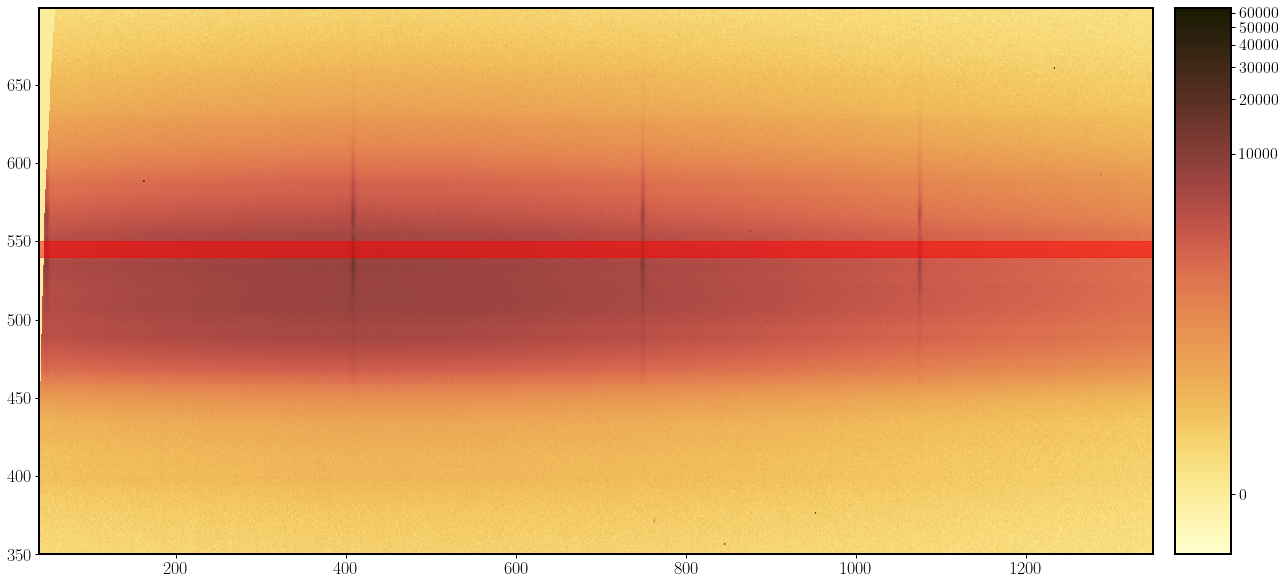

In [39]:
fig, ax = plt.subplots(figsize=(16,8),constrained_layout=True)
im = ax.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            totality_trans_mapcoor,norm=norm_totality,cmap=cmcm.lajolla,rasterized=True)
ax.tick_params(labelsize=18)
ax.axhspan(bottom_pixel,top_pixel,color="red",alpha=0.5)
clb_ax = inset_axes(ax,width="5%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
clb_ax.tick_params(labelsize=16)
clb_ax.yaxis.get_offset_text().set_fontsize(16)
clb_ax.set_ylabel('',fontsize=16)

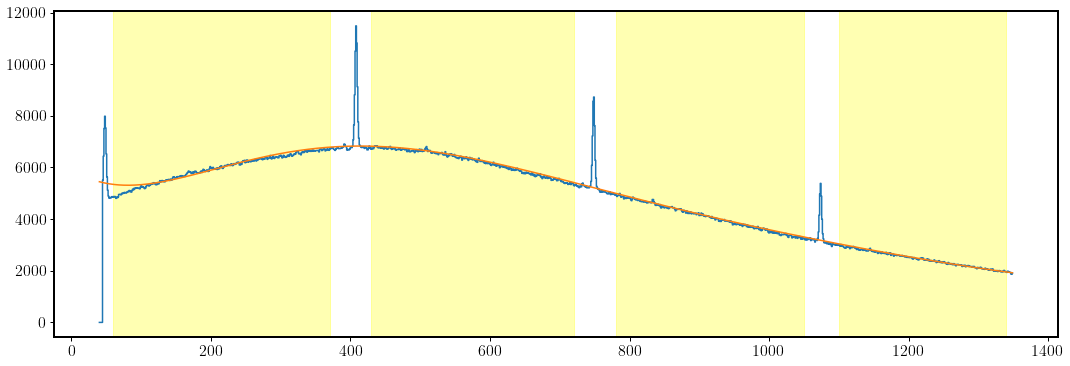

In [40]:
totality_spectrum_example = np.mean(totality_trans_mapcoor[bottom_pixel - ystart_pixel:top_pixel - ystart_pixel,:],axis=0)
fig, ax = plt.subplots(figsize=(18,6))
ax.step(ccdx_array, totality_spectrum_example,where="mid")
ax.tick_params(labelsize=16)

fit_intervals = [slice(60,370),slice(430,720),slice(780,1050),slice(1100,1340)]
for fit_interval in fit_intervals:
    ax.axvspan(fit_interval.start,fit_interval.stop,color="yellow",alpha=0.3)

background_poly_order = 7
wvl_array_to_fit = np.concatenate([ccdx_array[fit_interval] for fit_interval in fit_intervals])
spectra_to_fit = np.concatenate([totality_spectrum_example[fit_interval] for fit_interval in fit_intervals])
background_poly_params = np.polyfit(wvl_array_to_fit,spectra_to_fit,background_poly_order)
background_poly_func = np.poly1d(background_poly_params)
background_poly_curve = background_poly_func(ccdx_array)

ax.plot(ccdx_array, background_poly_curve, label="{:.0f}th".format(background_poly_order))

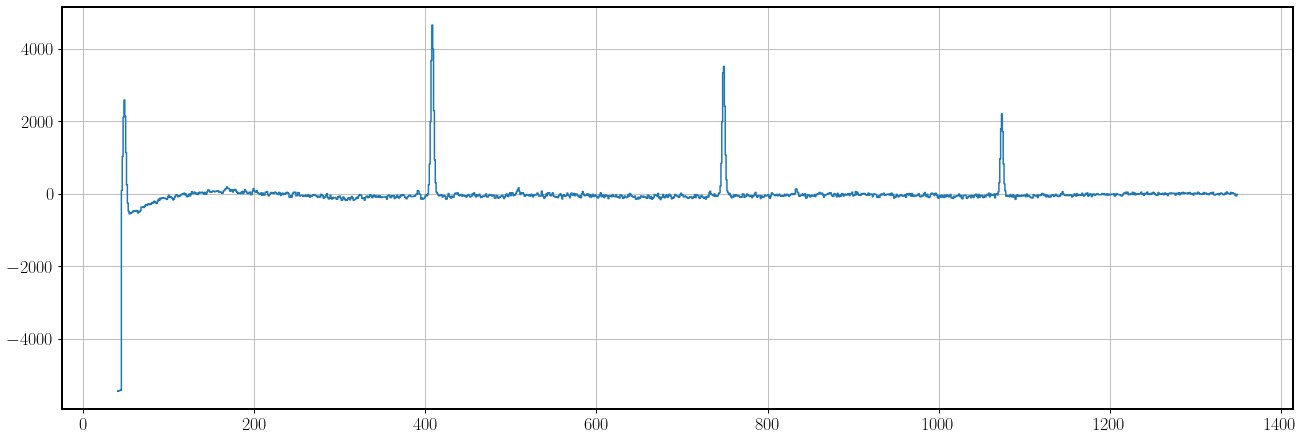

In [41]:
totality_spectrum_no_background = totality_spectrum_example - background_poly_curve
fig, ax = plt.subplots(figsize=(18,6),constrained_layout=True)
ax.step(ccdx_array, totality_spectrum_no_background, where="mid")
ax.tick_params(labelsize=18)
ax.grid("on")

In [42]:
# FeXIV_5303_slice_1 = slice(30,60)
# FeXIV_5303_model_1 = SpectrumFitSingle(data=totality_spectrum_no_background[FeXIV_5303_slice_1], wvl=ccdx_array[FeXIV_5303_slice_1],line_number=1,line_wvl_init=[44],
#                     int_max_init=[300],fwhm_init=[1],same_width=False)
# FeXIV_5303_model_1.run_lse(absolute_sigma=False)
# FeXIV_5303_model_1.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

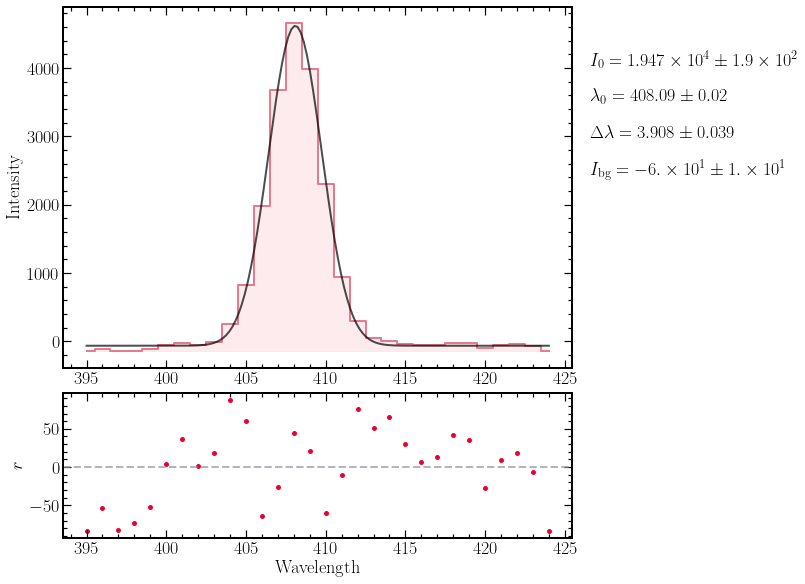

In [43]:
FeXIV_5303_slice_2 = slice(395 - xstart_pixel,425 - xstart_pixel)
FeXIV_5303_model_2 = SpectrumFitSingle(data=totality_spectrum_no_background[FeXIV_5303_slice_2], wvl=ccdx_array[FeXIV_5303_slice_2],line_number=1,line_wvl_init=[407],
                    int_max_init=[5000],fwhm_init=[1],same_width=False)
FeXIV_5303_model_2.run_lse(absolute_sigma=False)
FeXIV_5303_model_2.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

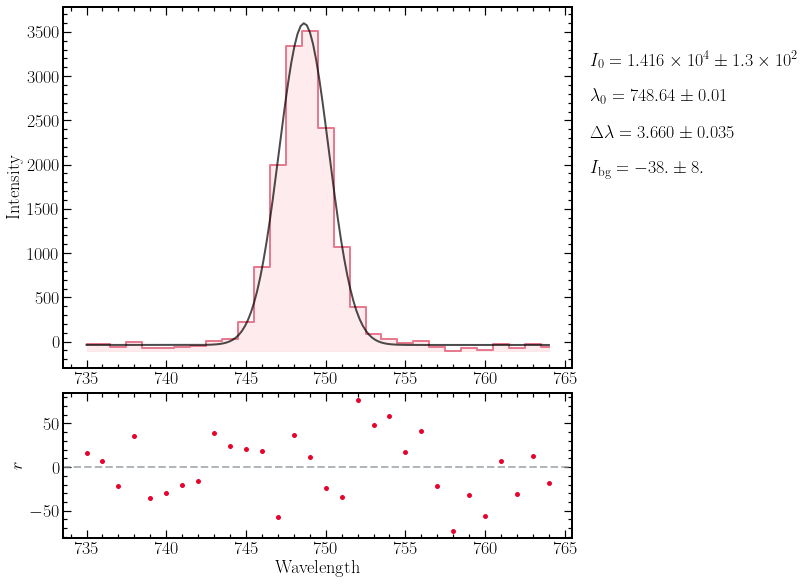

In [44]:
FeXIV_5303_slice_3 = slice(735 - xstart_pixel,765 - xstart_pixel)
FeXIV_5303_model_3 = SpectrumFitSingle(data=totality_spectrum_no_background[FeXIV_5303_slice_3], wvl=ccdx_array[FeXIV_5303_slice_3],line_number=1,line_wvl_init=[749],
                    int_max_init=[3500],fwhm_init=[1],same_width=False)
FeXIV_5303_model_3.run_lse(absolute_sigma=False)
FeXIV_5303_model_3.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

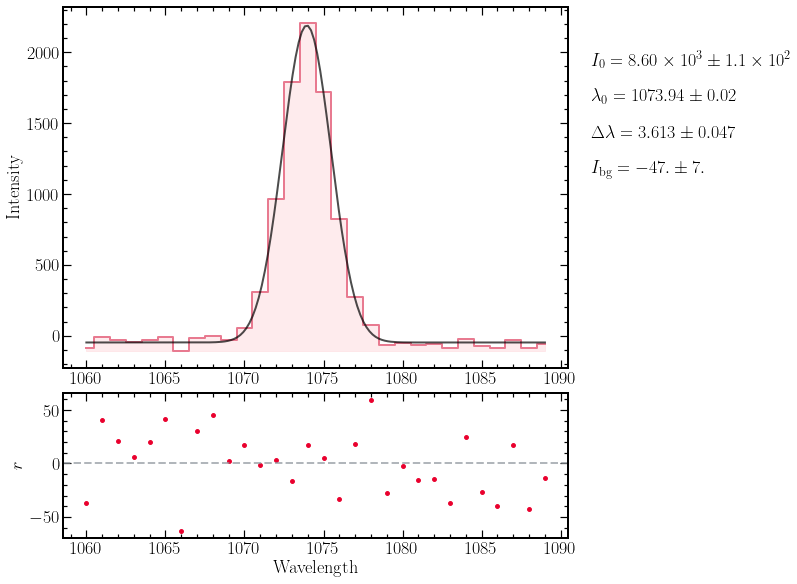

In [45]:
FeXIV_5303_slice_4 = slice(1060 - xstart_pixel,1090 - xstart_pixel)
FeXIV_5303_model_4 = SpectrumFitSingle(data=totality_spectrum_no_background[FeXIV_5303_slice_4], wvl=ccdx_array[FeXIV_5303_slice_4],line_number=1,line_wvl_init=[1075],
                    int_max_init=[2000],fwhm_init=[1],same_width=False)
FeXIV_5303_model_4.run_lse(absolute_sigma=False)
FeXIV_5303_model_4.plot(plot_fit=True)

In [46]:
# FeXIV_5303_slice_5 = slice(1375,1392)
# FeXIV_5303_model_5 = SpectrumFitSingle(data=totality_spectrum_example[FeXIV_5303_slice_5], wvl=ccdx_array[FeXIV_5303_slice_5],line_number=1,line_wvl_init=[1383],
#                     int_max_init=[3000],fwhm_init=[1],same_width=False)
# FeXIV_5303_model_5.run_lse(absolute_sigma=False)
# FeXIV_5303_model_5.plot(plot_fit=True)

In [47]:
for FeXIV_5303_model_ in (FeXIV_5303_model_2,FeXIV_5303_model_3,FeXIV_5303_model_4):
    print(poly_fit_func(FeXIV_5303_model_.line_wvl_fit[0])*base_order/5302.86)

63.017593278626656
62.01778995704164
61.018778691142415


In [48]:
FeXIV_5303_pos = np.array([FeXIV_5303_model.line_wvl_fit[0] for FeXIV_5303_model in 
                    (FeXIV_5303_model_2, FeXIV_5303_model_3,FeXIV_5303_model_4)])


Text(0.5, 0, '\\textbf{CCD-X [Pixel]}')

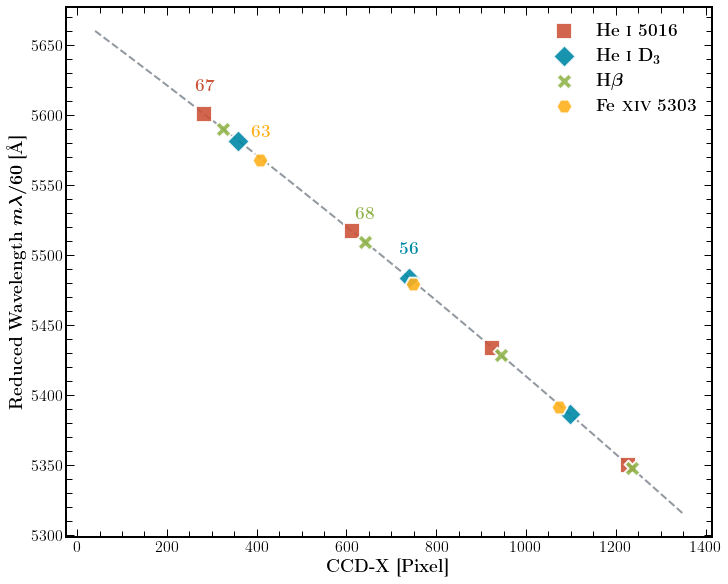

In [49]:
FeXIV_5303_start_order_guess = 63
FeXIV_5303_wvl_guess = 5302.86 * np.arange(FeXIV_5303_start_order_guess, FeXIV_5303_start_order_guess - 3, -1)/base_order

fig, ax = plt.subplots(figsize=(10,8),constrained_layout=True)

ln1 = ax.scatter(HeI_5016_pos, HeI_5016_wvl_guess,marker= "s",s=250,facecolor="#CC543A",
            alpha=0.9,edgecolor='white',linewidth=2,label=r"\textbf{He \textsc{i} 5016}")
ln2 = ax.scatter(HeI_D3_pos, HeI_D3_wvl_guess,marker= "D",s=250,facecolor="#0089A7",
            alpha=0.9,edgecolor='white',linewidth=2,label=r"\textbf{He \textsc{i} $\boldsymbol{\rm D_3}$}")
ln3 = ax.scatter(Hbeta_pos, Hbeta_wvl_guess,marker= "X",s=250,facecolor="#90B44B",
            alpha=0.9,edgecolor='white',linewidth=2,label=r"\textbf{H}$\boldsymbol{\beta}$")
ln4 = ax.scatter(FeXIV_5303_pos, FeXIV_5303_wvl_guess,marker= "H",s=250,facecolor="#FFB11B",
            alpha=0.9,edgecolor='white',linewidth=2,label=r"\textbf{Fe \textsc{xiv} 5303}")

leg = [ln1,ln2,ln3,ln4]
ax.legend(leg,[leg_.get_label() for leg_ in leg],loc = 'upper right',fontsize = 18,frameon=False)

ax.plot(ccdx_array, poly_fit_curve,lw=2,ls="--",color="#91989F",zorder=0)
ax.text(Hbeta_pos[1], Hbeta_wvl_guess[1]+20, r"\textbf{{{:2d}}}".format(Hbeta_start_order_guess-1),color="#90B44B",
        fontsize=18,ha="center",va="center")
ax.text(HeI_5016_pos[0], HeI_5016_wvl_guess[0]+20, r"\textbf{{{:2d}}}".format(HeI_5016_start_order_guess),color="#CC543A",
        fontsize=18,ha="center",va="center")
ax.text(HeI_D3_pos[1], HeI_D3_wvl_guess[1]+20, r"\textbf{{{:2d}}}".format(HeI_D3_start_order_guess-1),color="#0089A7",
        fontsize=18,ha="center",va="center")
ax.text(FeXIV_5303_pos[0], FeXIV_5303_wvl_guess[0]+20, r"\textbf{{{:2d}}}".format(FeXIV_5303_start_order_guess),color="#FFB11B",
        fontsize=18,ha="center",va="center")

ax.tick_params(labelsize=16,direction="in",which="both",right=True,top=True)
ax.tick_params(length=8,which="major")
ax.tick_params(length=6,which="minor")
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylabel(r"\textbf{Reduced Wavelength} $\boldsymbol{m\lambda/60}$ \textbf{[\mbox{\AA}]}",fontsize=18)
ax.set_xlabel(r"\textbf{CCD-X [Pixel]}",fontsize=18)
#plt.savefig(fname="../../figs/calib/wvl_calib_red_eclipse_2017.pdf",dpi=300)

In [50]:
with h5py.File("../../sav/Eclipse/Wavelength/master_wavelength_curvature_green.h5", 'w') as hf:
    df_wavelength = hf.create_dataset("wavelength_times_order",  data=poly_fit_curve * base_order)
    df_wavelength_abs = hf.create_dataset("wavelength_times_order_shift",  data=poly_fit_curve_shift * base_order)
    df_wavelength.attrs["xstart_pixel"] = xstart_pixel
    df_wavelength.attrs["xend_pixel"] = xend_pixel

In [52]:
helium_trans_mapcoor.shape

(350, 1310)

In [53]:
HeI_5016_model_2_row_data = np.average(helium_trans_mapcoor[:,HeI_5016_slice_2].reshape(-1,5,HeI_5016_slice_2.stop - HeI_5016_slice_2.start),axis=1)
HeI_5016_model_2_row = SpectrumFitRow(data=HeI_5016_model_2_row_data, wvl=ccdx_array[HeI_5016_slice_2],line_number=1,line_wvl_init=[612],
                    int_max_init=[5000],fwhm_init=[2],same_width=False)
HeI_5016_model_2_row.run_lse()

/home/yjzhu/SOLAR/MyPy/juanfit.py:204: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")


<AxesSubplot:ylabel='FWHM $\\Delta \\lambda$'>

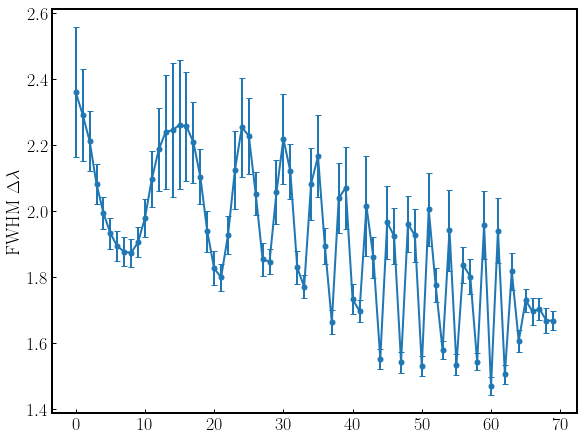

In [54]:
HeI_5016_model_2_row.plot_variation()

array([[<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<A

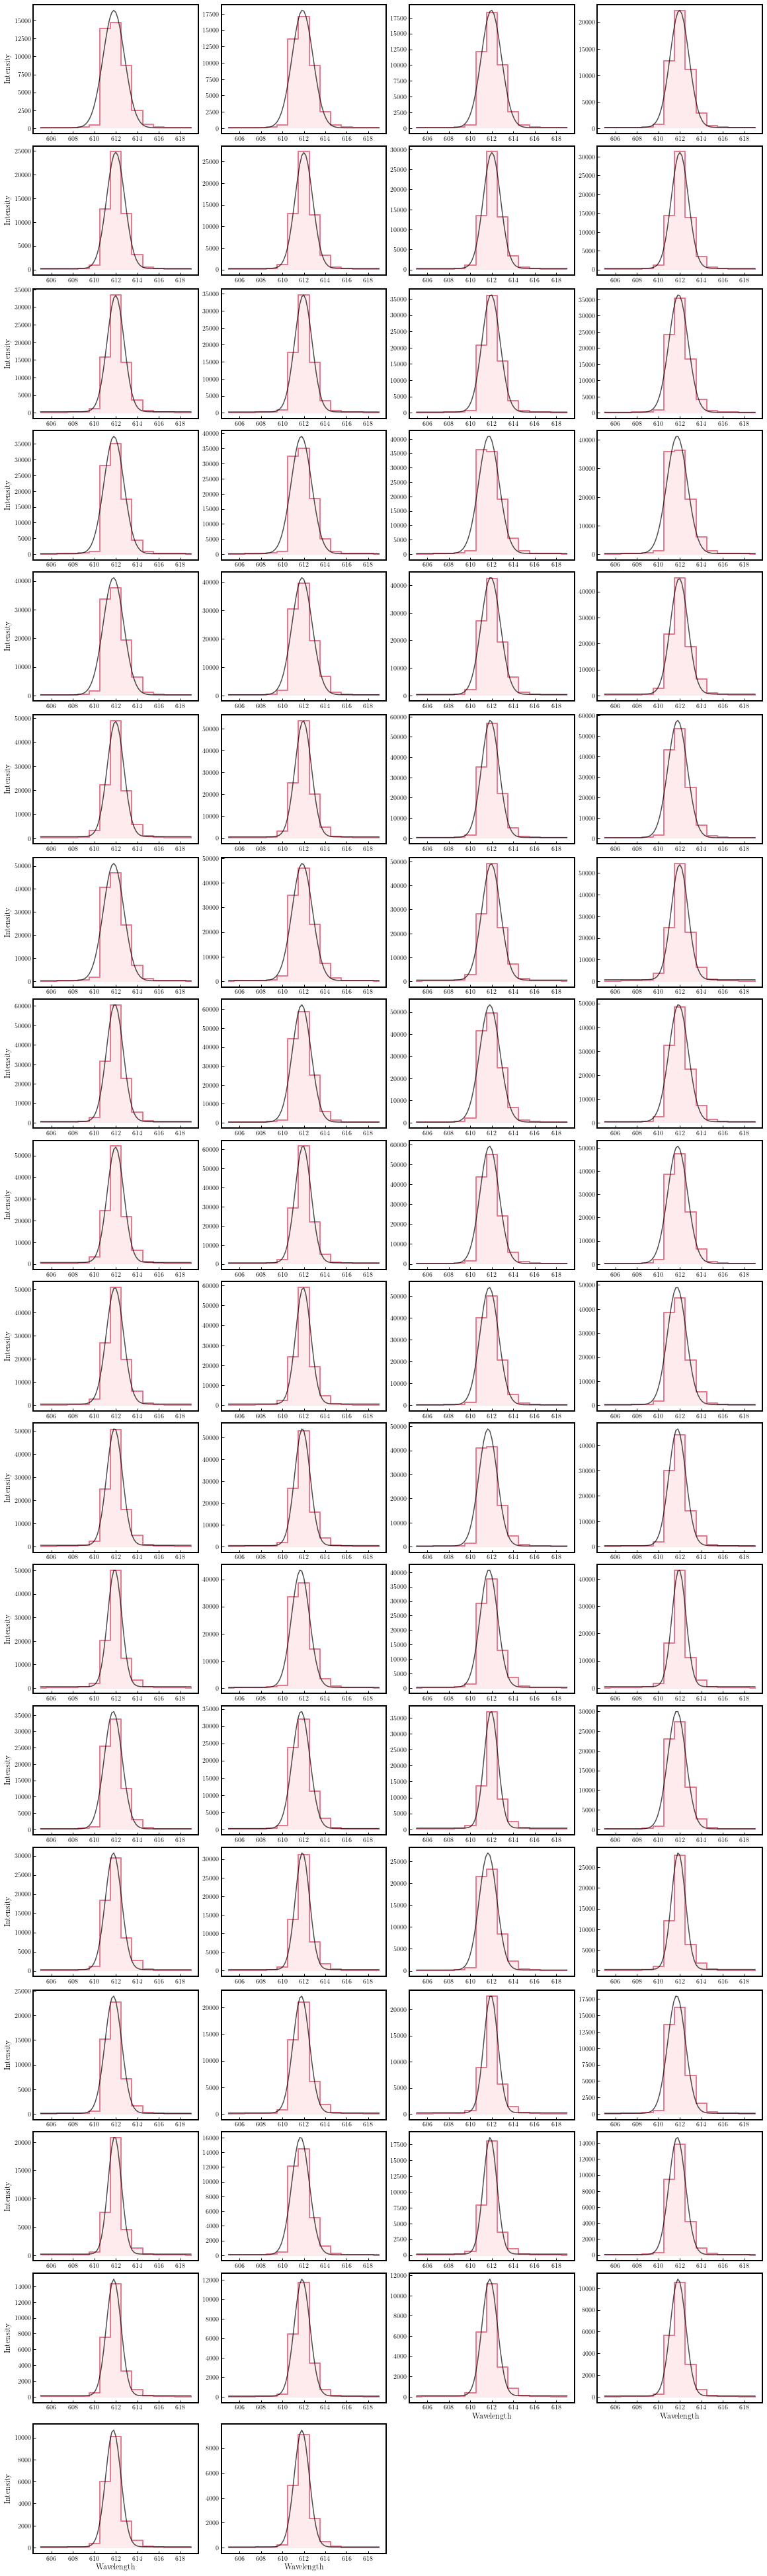

In [55]:
HeI_5016_model_2_row.plot_fit()

In [57]:
Hbeta_model_2_row_data = np.average(hydrogen_trans_mapcoor[:,Hbeta_slice_2].reshape(-1,5,Hbeta_slice_2.stop - Hbeta_slice_2.start),axis=1)
Hbeta_model_2_row = SpectrumFitRow(data=Hbeta_model_2_row_data, wvl=ccdx_array[Hbeta_slice_2],line_number=1,line_wvl_init=[642],
                    int_max_init=[12000],fwhm_init=[1],same_width=False,mask=[[644,654]])
Hbeta_model_2_row.run_lse()

/home/yjzhu/SOLAR/MyPy/juanfit.py:204: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")


<AxesSubplot:ylabel='FWHM $\\Delta \\lambda$'>

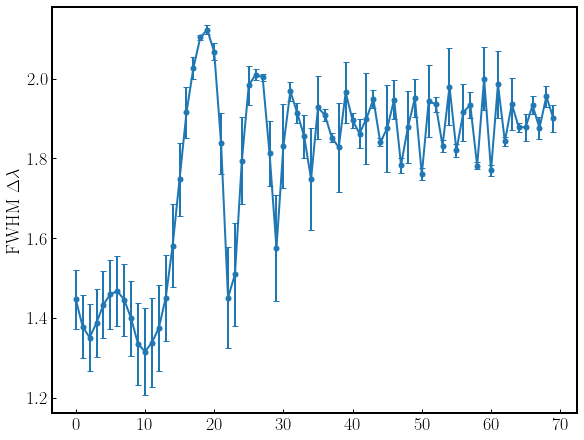

In [58]:
Hbeta_model_2_row.plot_variation()

array([[<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<A

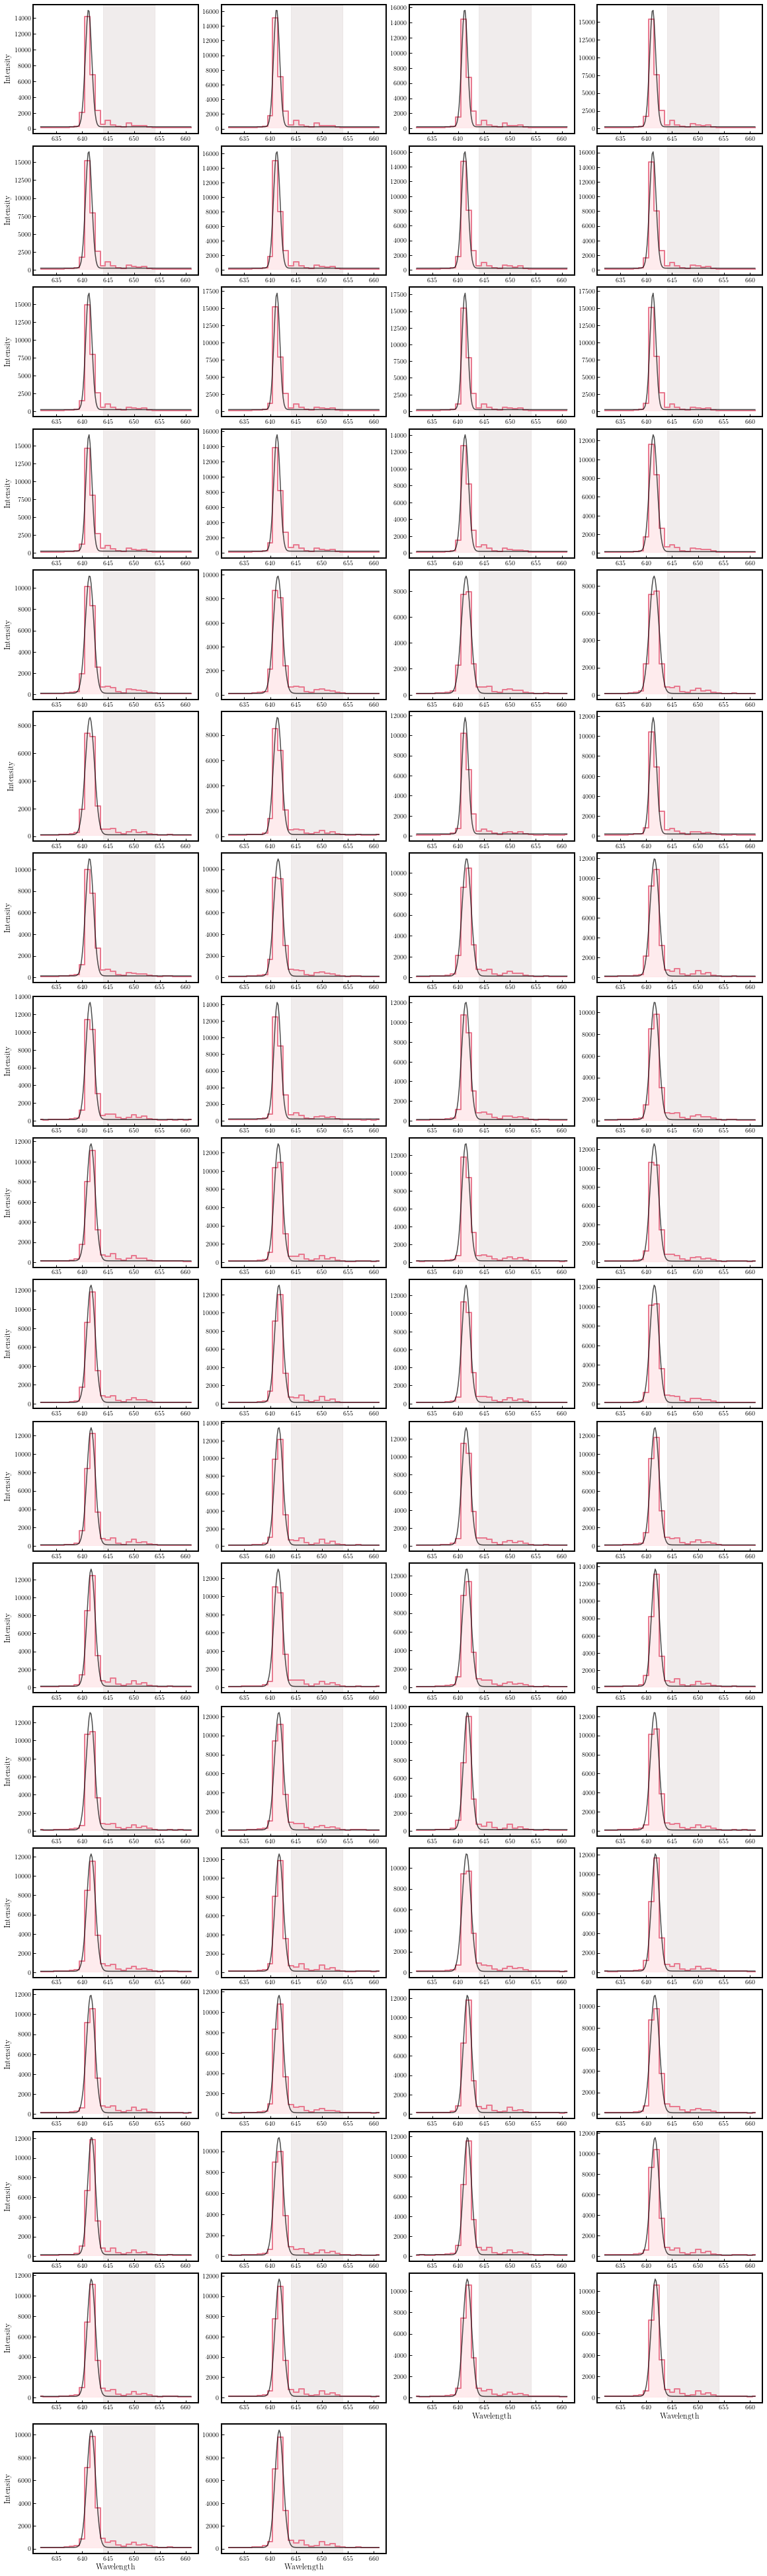

In [59]:
Hbeta_model_2_row.plot_fit()